실행하기 위한 환경설정

1. wordcloud에서 한글폰트 설정(matplotlib fontmanager을 통한 한글폰트 지정 필요)

In [ ]:
! pip install wordcloud

2. 자연어 처리 라이브러리 설치

1) jre 설치url: java.com/en/download

2) jpype 설치

In [38]:
! pip install JPype1-1.2.0-cp38-cp38-win_amd64.whl

Processing c:\users\82102\desktop\유튜브_주식지표 상관관계\jpype1-1.2.0-cp38-cp38-win_amd64.whl


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\82102\\Desktop\\유튜브_주식지표 상관관계\\JPype1-1.2.0-cp38-cp38-win_amd64.whl'

You should consider upgrading via the 'c:\users\82102\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


3) nltk konlpy 설치

In [ ]:
! pip install nltk konlpy

3. 모델 학습 라이브러리 설치(설치 후 주피터 노트북을 닫고 관리자 권한으로 cmd창을 열고 재실행)

In [ ]:
! pip install tensorflow

#1 학습데이터 전처리

In [2]:
import pandas as pd

train_df = pd.read_csv("ratings_train.txt", "\t")
test_df = pd.read_csv("ratings_test.txt", "\t")

In [3]:
from konlpy.tag import Okt
okt = Okt()
okt.pos(u'흔들리는 꽃들 속에서 네 샴푸향이 느껴진거야')

[('흔들리는', 'Verb'),
 ('꽃', 'Noun'),
 ('들', 'Suffix'),
 ('속', 'Noun'),
 ('에서', 'Josa'),
 ('네', 'Noun'),
 ('샴푸', 'Noun'),
 ('향', 'Noun'),
 ('이', 'Josa'),
 ('느껴진거야', 'Verb')]

In [4]:
def tokenize(doc):
    #형태소와 품사를 join
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

In [5]:
train_df.isnull().any() #document에 null값이 있다.
train_df['document'] = train_df['document'].fillna(''); #null값을 ''값으로 대체

test_df.isnull().any()
test_df['document'] = test_df['document'].fillna(''); #null값을 ''값으로 대체

In [6]:
#tokenize 과정은 시간이 오래 걸릴수 있음...
train_docs = [(tokenize(row[1]), row[2]) for row in train_df.values]
test_docs = [(tokenize(row[1]), row[2]) for row in test_df.values]

In [7]:
print(train_docs[0])
print(test_docs[0])

(['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증나다/Adjective', '목소리/Noun'], 0)
(['굳다/Adjective', 'ㅋ/KoreanParticle'], 1)


In [8]:
tokens = [t for d in train_docs for t in d[0]]
print("토큰개수:", len(tokens))

토큰개수: 2159921


In [9]:
import nltk
text = nltk.Text(tokens, name='NMSC')

#토큰개수
print(len(text.tokens))

#중복을 제외한 토큰개수
print(len(set(text.tokens)))

#출력빈도가 높은 상위 토큰 10개
print(text.vocab().most_common(10))

2159921
49894
[('./Punctuation', 67778), ('영화/Noun', 50818), ('하다/Verb', 41209), ('이/Josa', 38540), ('보다/Verb', 38538), ('의/Josa', 30188), ('../Punctuation', 29055), ('가/Josa', 26627), ('에/Josa', 26468), ('을/Josa', 23118)]


In [10]:
%matplotlib inline

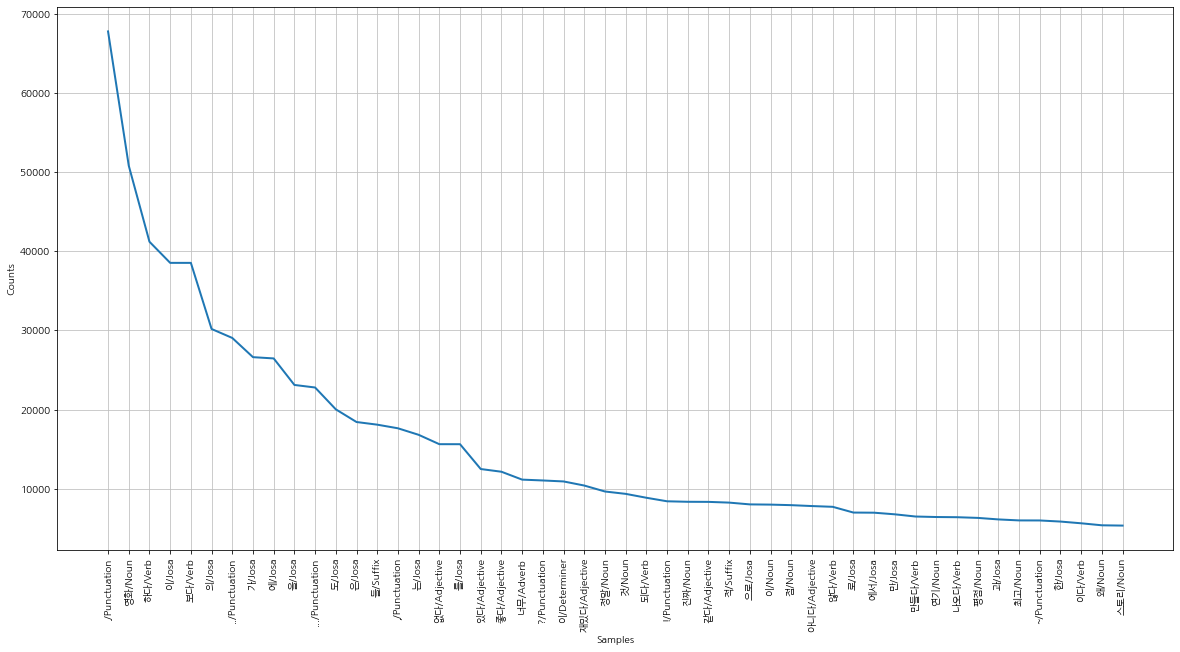

In [11]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NanumGothic.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.figure(figsize=(20,10))
text.plot(50)

In [12]:
FREQUENCY_COUNT = 100 #시간적 여유가 있다면 10000개를 해보도록~

In [13]:
selected_words = [f[0] for f in text.vocab().most_common(FREQUENCY_COUNT)]

In [14]:
#단어리스트 문서에서 상위 10000개들중 포함되는 단어들이 개수
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

In [15]:
#문서에 들어가는 단어 개수
x_train = [term_frequency(d) for d,_ in train_docs]
x_test = [term_frequency(d) for d,_ in test_docs]

In [16]:
#라벨(1 or 0)
y_train = [c for _,c in train_docs]
y_test = [c for _,c in test_docs]

In [17]:
import numpy as np
x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

#2 모델 학습

In [18]:
import tensorflow as tf

#레이어 구성
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(FREQUENCY_COUNT,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
#학습 프로세스 설정
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=[tf.keras.metrics.binary_accuracy]
    )

c:\users\82102\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [22]:
#학습 데이터로 학습
model.fit(x_train, y_train, epochs=10, batch_size=512)

Epoch 1/10
293/293 [==============================] - 1s 1ms/step - loss: 0.5611 - binary_accuracy: 0.6976
Epoch 2/10
293/293 [==============================] - 0s 1ms/step - loss: 0.5302 - binary_accuracy: 0.7132
Epoch 3/10
293/293 [==============================] - 0s 1ms/step - loss: 0.5224 - binary_accuracy: 0.7188
Epoch 4/10
293/293 [==============================] - 0s 1ms/step - loss: 0.5167 - binary_accuracy: 0.7217
Epoch 5/10
293/293 [==============================] - 0s 1ms/step - loss: 0.5122 - binary_accuracy: 0.7252
Epoch 6/10
293/293 [==============================] - 0s 1ms/step - loss: 0.5082 - binary_accuracy: 0.7286
Epoch 7/10
293/293 [==============================] - 0s 1ms/step - loss: 0.5056 - binary_accuracy: 0.7293
Epoch 8/10
293/293 [==============================] - 0s 1ms/step - loss: 0.5032 - binary_accuracy: 0.7317
Epoch 9/10
293/293 [==============================] - 0s 1ms/step - loss: 0.5009 - binary_accuracy: 0.7336
Epoch 10/10
293/293 [================

In [23]:
results = model.evaluate(x_test, y_test)

1563/1563 [==============================] - 1s 497us/step - loss: 0.5214 - binary_accuracy: 0.7161


In [24]:
#loss: 0.5, acc: 0.7
results

[0.5214105844497681, 0.7160800099372864]

#3 학습된 모델을 이용한 감성분석

In [32]:
#모델을 저장해둘수도 있다.
#model.save('movie_review_model.h5')

# 모델 불러오기
from keras.models import load_model
model = load_model('movie_review_model.h5')

In [33]:
review = "아주 재미 있어요"
token = tokenize(review)
token

['아주/Noun', '재미/Noun', '있다/Adjective']

In [34]:
tf = term_frequency(token)

In [35]:
data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)

In [36]:
float(model.predict(data))

0.9293605089187622

In [30]:
def predict_review(review):
    token = tokenize(review)
    tfq = term_frequency(token)
    data = np.expand_dims(np.asarray(tfq).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print(f"{review} ==> 긍정 ({round(score*100)}%)")
    else:
        print(f"{review} ==> 부정 ({round((1-score)*100)}%)")

In [31]:
predict_review("재미 정말 없어요")

재미 정말 없어요 ==> 부정 (92%)
